# Les CART

Avant de démarrer les Random Forest, il est **nécessaire de bien comprendre le fonctionnement, et surtout le processus d'optimisation (de calibrage) des arbres de décisions**. En effet, rappelons que l'idée derrière les Random Forest est une méthode d'ensemble (de paquets), c'est-à-dire qu'elle se base sur plusieurs arbres afin d'obtenir un modèle complexe.

## Exemple simulé

Commencons par un exemple afin de comprendre le fonctionnement d'un arbre de régression.

### Simulation de données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

Pour cet exemple, nous simulons une fonction sinus avec des bruits aléatoires et indépendants.

In [2]:
# le random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
# le bruit ajouté 
y[::5] += 3 * (0.5 - rng.rand(16))

### Les arbres de régression

Nous allons créer $4$ arbres de régression ayant une profondeur différente (respectivement 2, 3, 4 et 6). Pour chacun des arbres :

- On crée l'objet *scikit-learn* permettant d'effectuer la régression par un arbre de décision
- On optimise l'arbre sur nos données
- On prédit l'arbre sur des données simulés

In [3]:
# Fit regression model
regressors = []
depths = [2, 3, 4, 6]
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
Y_test = []
for p in depths:
    reg = DecisionTreeRegressor(max_depth=p)  # Création d'un arbre de régression de profondeur p
    reg.fit(X, y)  # Processus d'optimisation de l'arbre
    Y_test.append(reg.predict(X_test))  # On prédit sur les données et on ajoute à la liste des valeurs prédites
    regressors.append(reg)

Enfin, nous pouvons afficher les données d'entrées et les valeurs prédites pour chaque arbre.

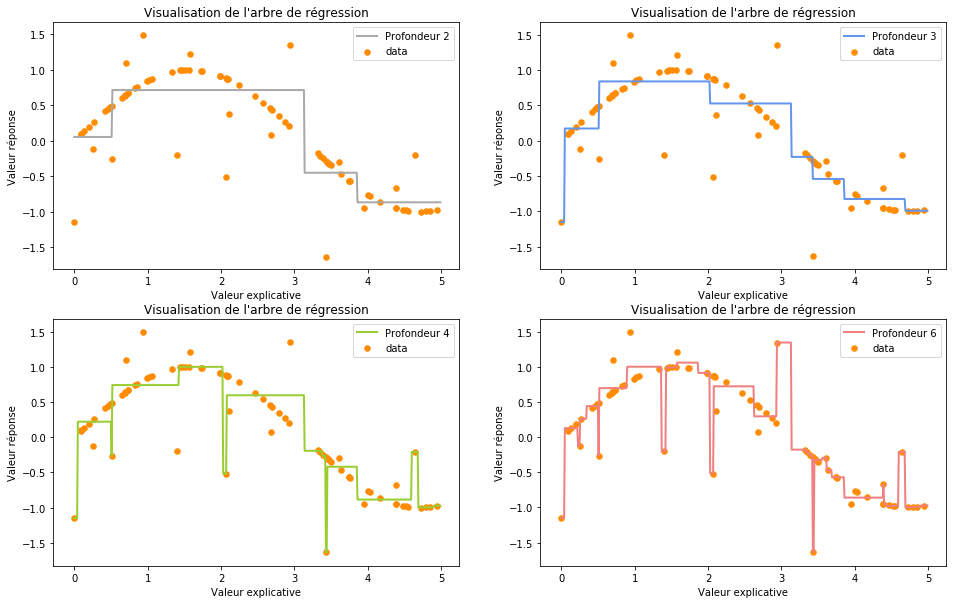

In [4]:
plt.figure(figsize=(16, 10))
colors = [ "darkgray", "cornflowerblue", "yellowgreen", "lightcoral"]

for i, reg in zip(range(len(regressors)), regressors):
    plt.subplot(220 + i + 1)
    plt.plot(X_test, Y_test[i], color=colors[i], label="Profondeur {0}".format(depths[i]), linewidth=2)
    plt.scatter(X, y, s=30, c="darkorange", label="data")
    plt.xlabel("Valeur explicative")
    plt.ylabel("Valeur réponse")
    plt.title("Visualisation de l'arbre de régression")
    plt.legend()
    
plt.show()

Comparez les graphiques obtenus.

### Explication

On ne considère que l'arbre de profondeur $d=2$. Si $d=2$, alors il y a $3$ **splits** (ou coupures), notés $t_1, t_2$ et $t_3$. Commençons par le début :

Initialement, il n'y a pas de coupure. On s'interroge donc à comment calculer $t_1$, pour obtenir la règle $X \leq t_1$. Pour cela, on doit introduire une **métrique de perte**, c'est-à-dire une fonction qui nous indique si la coupure est bonne ou pas. Tout comme pour la régression linéaire, nous avons naturellement envie de considérer la distance des moindres carrés entre la valeur théorique $y$ et la valeur prédire $\hat{y}$. On veut donc couper de sorte à **minimiser** cette perte quadratique à gauche de $t_1$, mais également à droite de $t_1$.

Soyons plus formel. Appelons $R_G = \{ X : X \leq t_1 \}$ l'ensemble à gauche de $t_1$ et $R_D=\{ X : X > t_1 \}$ l'ensemble à droite de $t_1$. On a dit vouloir minimiser la perte quadratique, c'est-à-dire résoudre

$$\min_{t_1 \in \mathbb{R}} \sum_{i=1}^n (y_i-\hat{y})$$

Problème : $t_1$ n'intervient pas dans la somme ! Puisqu'il s'agit d'un split, il faut à la fois considérer lorsque le point est soit dans $R_G$, soit dans $R_D$. De plus, puisque l'on veut attribuer un poids à chaque noeud, qui ici définira la valeur prédite $\hat{y}$, nous devons introduire $c_G$ et $c_D$, que l'on interprète comme ceci :

- Tous les points $X$ qui appartiennent à $R_G$ (soit inférieurs à $t_1$) auront pour valeur prédite $c_G$.
- Tous les points $X$ qui appartiennent à $R_D$ (soit strictement supérieurs à $t_1$) auront pour valeur prédite $c_D$.

Mais ces poids doivent aussi être optimisés afin d'être calibré selon nos données. Dès lors, on obtient une formule beaucoup plus applicable numériquement :

$$\min_{t_1 \in \mathbb{R}} \left(\min_{c_G \in \mathbb{R}} \sum_{x_i \in R_G} (y_i-c_G)^2 +\min_{c_D \in \mathbb{R}} \sum_{x_i \in R_D} (y_i-c_D)^2 \right)$$

On peut simplifier le problème tel que :

$$\min_{t_1 \in \mathbb{R}} \left( \sum_{x_i \in R_G} (y_i-\hat{c_G})^2 + \sum_{x_i \in R_D} (y_i-\hat{c_D})^2 \right)$$

### Visualisation de l'arbre

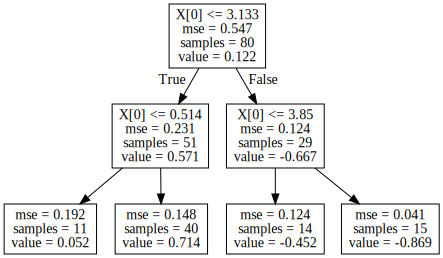

In [5]:
import graphviz 
dot_data = tree.export_graphviz(regressors[0], out_file=None) 
graph = graphviz.Source(dot_data) 
graph

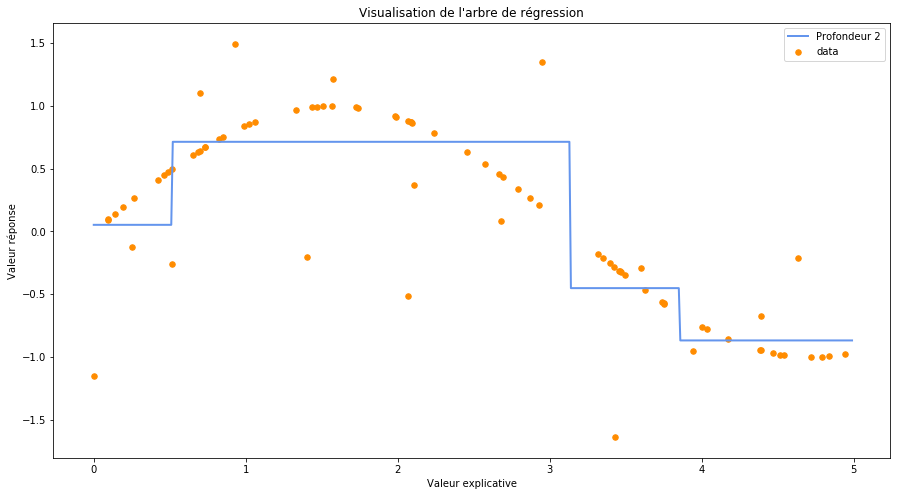

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(X_test, Y_test[0], color="cornflowerblue", label="Profondeur 2", linewidth=2)
plt.scatter(X, y, s=30, c="darkorange", label="data")
plt.xlabel("Valeur explicative")
plt.ylabel("Valeur réponse")
plt.title("Visualisation de l'arbre de régression")
plt.legend()
    
plt.show()